# Modeling - Experience Level Classification

## Classificazione Multiclasse del Livello di Esperienza

---

**Autore:** Alessandro Ambrosio  
**Dataset:** STATUS_final.csv  
**Task:** Classificazione multiclasse (3 livelli)

## Pipeline Completa di Machine Learning

---

**Dataset:** 508 utenti, 19 feature (seed=99999)  
**Split:** 406 train / 102 test (80/20 stratificato)  
**Best Model:** Random Forest - Test Accuracy **98.0%**  
**Cross-Validation:** 99.8% ± 0.5% (5-fold)  

---

## Pipeline Overview

```
1. DATA GENERATION     → 508 utenti, 8 settimane, 10+ esercizi
2. FEATURE ENGINEERING → 50 feature → 19 feature finali
3. MODELING (qui)      → 4 algoritmi, tuning, validation
```

---

## Modelli Testati

| Modello | Test Acc | CV Score | Interpretazione |
|---------|----------|----------|------------------|
| Decision Tree | 98.0% | - | Baseline, interpretabile |
| **Random Forest** | **98.0%** | **99.8% ± 0.5%** | **BEST** - Robusto |
| XGBoost | 97.1% | 99.5% ± 0.6% | Performance alta |
| SVM | 99.0% | 97.8% ± 1.4% | Best test, CV più variabile |

---
---

## Contesto del Progetto

Questo notebook rappresenta la **terza e ultima fase** del progetto:

1. **Data Generation** → Creazione dataset sintetico fitness tracking
2. **Feature Engineering** → Trasformazione e selezione feature (18 feature finali)
3. **Modeling** → Sviluppo e validazione modelli predittivi *(questo notebook)*

---

## Obiettivo

**Predire il livello di esperienza** (Beginner/Intermediate/Advanced) analizzando:
- Carichi sollevati (load_mean, load per esercizio)
- Volume e frequenza
- Comportamento (skip_rate, consistenza)
- RPE (Rating of Perceived Exertion)

---

## Approccio Metodologico

### **1. Preparazione Dati**
- Train/Test split stratificato (80/20)
- StandardScaler per normalizzazione

### **2. Model Selection**
Testeremo **4 algoritmi** con caratteristiche diverse:

| Modello | Pro | Contro | Uso Ideale |
|---------|-----|--------|------------|
| **Decision Tree** | Interpretabile, veloce | Overfitting | Baseline |
| **Random Forest** | Robusto, ensemble | Meno interpretabile | Produzione |
| **XGBoost** | Performance ottimali | Hyperparameter complessi | Competizioni |
| **SVM** | Efficace in high-dim | Lento su grandi dataset | Medie dimensioni |

### **3. Validazione**
- Cross-validation 5-fold
- Hyperparameter tuning
- Feature importance

---

---
#  SEZIONE 1: Setup & Import Librerie

Importazione di tutte le librerie necessarie per ML pipeline completa.

---


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

print("="*80)
print("MODELING - INIZIALIZZAZIONE")
print("="*80)
print(" (OK) Librerie caricate")
print("="*80)

MODELING - INIZIALIZZAZIONE
 (OK) Librerie caricate


---
# SEZIONE 2: Caricamento Dataset

Caricamento **STATUS_final.csv** (508 utenti, 19 feature post-engineering). Analisi distribuzione target.

---


In [8]:
print("="*80)
print("CARICAMENTO DATASET")
print("="*80)

df = pd.read_csv('STATUS_final.csv')
print(f"\n(OK) Dataset: {len(df)} righe, {len(df.columns)} colonne")

print(f"\n📊 DISTRIBUZIONE TARGET:")
for level, count in df['experience_label'].value_counts().sort_index().items():
    pct = count / len(df) * 100
    bar = '█' * int(pct / 2)
    print(f"  {level:12s}: {count:3d} ({pct:5.1f}%) {bar}")

print("="*80)

CARICAMENTO DATASET

(OK) Dataset: 508 righe, 22 colonne

📊 DISTRIBUZIONE TARGET:
  Advanced    :  60 ( 11.8%) █████
  Beginner    : 179 ( 35.2%) █████████████████
  Intermediate: 269 ( 53.0%) ██████████████████████████


---
# SEZIONE 3: Exploratory Data Analysis

**Top correlazioni** feature-target. Identifica variabili più predittive (load_mean r=0.961).

---


In [9]:
print("="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

metadata_cols = ['userid', 'experience_label']
target_col = 'target_encoded'
feature_cols = [c for c in df.columns if c not in metadata_cols + [target_col]]

print(f"\nFeatures: {len(feature_cols)}")
for i, col in enumerate(feature_cols[:10], 1):
    print(f"  {i:2d}. {col}")
if len(feature_cols) > 10:
    print(f"  ... e altre {len(feature_cols) - 10}")

print(f"\nTOP 5 CORRELAZIONI CON TARGET:")
corr = df[feature_cols].corrwith(df[target_col]).abs().sort_values(ascending=False)
for i, (feat, val) in enumerate(corr.head(5).items(), 1):
    strength = "(!!!) FORTE" if val > 0.7 else "(!!) MOD" if val > 0.3 else "(!) DEBOLE"
    print(f"  {i}. {feat:<35s}: r = {val:.3f} {strength}")

print("="*80)

EXPLORATORY DATA ANALYSIS

Features: 19
   1. observed_freq_weekly
   2. load_mean
   3. reps_std
   4. rpe_max
   5. load_volume_product
   6. completion_rate
   7. freq_gap
   8. load_barbell_row
   9. load_bench_press
  10. load_cable_fly
  ... e altre 9

TOP 5 CORRELAZIONI CON TARGET:
  1. load_mean                          : r = 0.961 (!!!) FORTE
  2. load_seated_cable_row              : r = 0.726 (!!!) FORTE
  3. load_barbell_row                   : r = 0.647 (!!) MOD
  4. load_lat_pulldown                  : r = 0.611 (!!) MOD
  5. load_bench_press                   : r = 0.564 (!!) MOD


---
# SEZIONE 4: Train/Test Split & Scaling

**80/20 stratificato** + **StandardScaler** (μ=0, σ=1). Necessario per SVM/XGBoost.

---


In [10]:
print("="*80)
print("TRAIN/TEST SPLIT & SCALING")
print("="*80)

X = df[feature_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n(OK) Split: Train {len(X_train)} | Test {len(X_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"(OK) Scaling applicato (μ={X_train_scaled.mean():.6f}, σ={X_train_scaled.std():.6f})")
print("="*80)

TRAIN/TEST SPLIT & SCALING

(OK) Split: Train 406 | Test 102
(OK) Scaling applicato (μ=0.000000, σ=1.000000)


---
# SEZIONE 5: Decision Tree (Baseline)

**Baseline interpretabile**. Singolo albero max_depth=5. Stabilisce performance minime da superare.

---


In [11]:
print("="*80)
print("BASELINE - DECISION TREE")
print("="*80)

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

train_acc_dt = dt.score(X_train, y_train)
test_acc_dt = dt.score(X_test, y_test)

print(f"\nTrain: {train_acc_dt:.3f} | Test: {test_acc_dt:.3f} | Gap: {(train_acc_dt-test_acc_dt):+.3f}")
print("="*80)

BASELINE - DECISION TREE

Train: 1.000 | Test: 0.980 | Gap: +0.020


---
# SEZIONE 6: Random Forest

**Ensemble di 100 alberi**. Riduce overfitting via bagging. **CV 5-fold** per validazione robusta.

---


In [15]:
print("="*80)
print("RANDOM FOREST")
print("="*80)

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

train_acc_rf = rf.score(X_train_scaled, y_train)
test_acc_rf = rf.score(X_test_scaled, y_test)
cv_rf = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"\nTrain: {train_acc_rf:.3f} | Test: {test_acc_rf:.3f} | CV: {cv_rf.mean():.3f}±{cv_rf.std():.3f}")
print(f"Improvement vs DT: {(test_acc_rf-test_acc_dt)*100:+.1f}%")
print("="*80)

RANDOM FOREST

Train: 1.000 | Test: 0.980 | CV: 0.998±0.005
Improvement vs DT: +0.0%


---
# SEZIONE 7: XGBoost

**Gradient Boosting**: alberi sequenziali che correggono errori. Top performance.
---

In [12]:
print("="*80)
print("XGBOOST")
print("="*80)

xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb.fit(X_train_scaled, y_train)

train_acc_xgb = xgb.score(X_train_scaled, y_train)
test_acc_xgb = xgb.score(X_test_scaled, y_test)
cv_xgb = cross_val_score(xgb, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"\nTrain: {train_acc_xgb:.3f} | Test: {test_acc_xgb:.3f} | CV: {cv_xgb.mean():.3f}±{cv_xgb.std():.3f}")
print("="*80)

XGBOOST

Train: 1.000 | Test: 0.971 | CV: 0.995±0.006


---
# SEZIONE 8: SVM

**Kernel RBF** per separazione non-lineare. Sensibile a scaling.
---

In [13]:
print("="*80)
print("SVM")
print("="*80)

svm = SVC(kernel='rbf', C=1.0, random_state=42)
svm.fit(X_train_scaled, y_train)

train_acc_svm = svm.score(X_train_scaled, y_train)
test_acc_svm = svm.score(X_test_scaled, y_test)
cv_svm = cross_val_score(svm, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"\nTrain: {train_acc_svm:.3f} | Test: {test_acc_svm:.3f} | CV: {cv_svm.mean():.3f}±{cv_svm.std():.3f}")
print("="*80)

SVM

Train: 1.000 | Test: 0.990 | CV: 0.978±0.014


---
# SEZIONE 9: Confronto Modelli

Identifica **best model** per test accuracy.
---

In [17]:
print("="*80)
print("CONFRONTO MODELLI")
print("="*80)

results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost', 'SVM'],
    'Test Acc': [test_acc_dt, test_acc_rf, test_acc_xgb, test_acc_svm],
    'CV Mean': [0, cv_rf.mean(), cv_xgb.mean(), cv_svm.mean()]
}).sort_values('Test Acc', ascending=False)

print("\n" + results.to_string(index=False))

best_model_name = results.iloc[0]['Model']
print(f"\n(!!) BEST MODEL (!!): {best_model_name}")
print(f"   Test Acc: {results.iloc[0]['Test Acc']:.3f}")
print("="*80)

CONFRONTO MODELLI

        Model  Test Acc  CV Mean
          SVM  0.990196 0.977838
Decision Tree  0.980392 0.000000
Random Forest  0.980392 0.997561
      XGBoost  0.970588 0.995092

(!!) BEST MODEL (!!): SVM
   Test Acc: 0.990


---
# SEZIONE 10: Hyperparameter Tuning

**GridSearchCV** su Random Forest (18 combinazioni × 5 folds = 90 fit).
---

In [19]:
print("="*80)
print("HYPERPARAMETER TUNING")
print("="*80)

param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5]}

print("\nGrid Search (1-2 min)...\n")
grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

print(f"\n(OK) Best params: {grid.best_params_}")
print(f"Best CV: {grid.best_score_:.3f}")

best_model = grid.best_estimator_
test_acc_best = best_model.score(X_test_scaled, y_test)
print(f"Test Acc: {test_acc_best:.3f}")
print(f"Improvement: {(test_acc_best-test_acc_rf)*100:+.1f}%")
print("="*80)

HYPERPARAMETER TUNING

Grid Search (1-2 min)...

Fitting 5 folds for each of 18 candidates, totalling 90 fits

(OK) Best params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best CV: 0.998
Test Acc: 0.980
Improvement: +0.0%


---
# SEZIONE 11: Feature Importance

**Top 10 feature** più rilevanti per predizione.
---

FEATURE IMPORTANCE

Top 10:
  load_mean                          : 0.2697
  load_barbell_row                   : 0.1401
  load_seated_cable_row              : 0.1291
  load_lat_pulldown                  : 0.0867
  load_incline_db_press              : 0.0666
  load_cable_fly                     : 0.0631
  load_bench_press                   : 0.0601
  load_leg_press                     : 0.0564
  load_squat                         : 0.0453
  load_romanian_deadlift             : 0.0311

(OK) Salvato: feature_importance.png


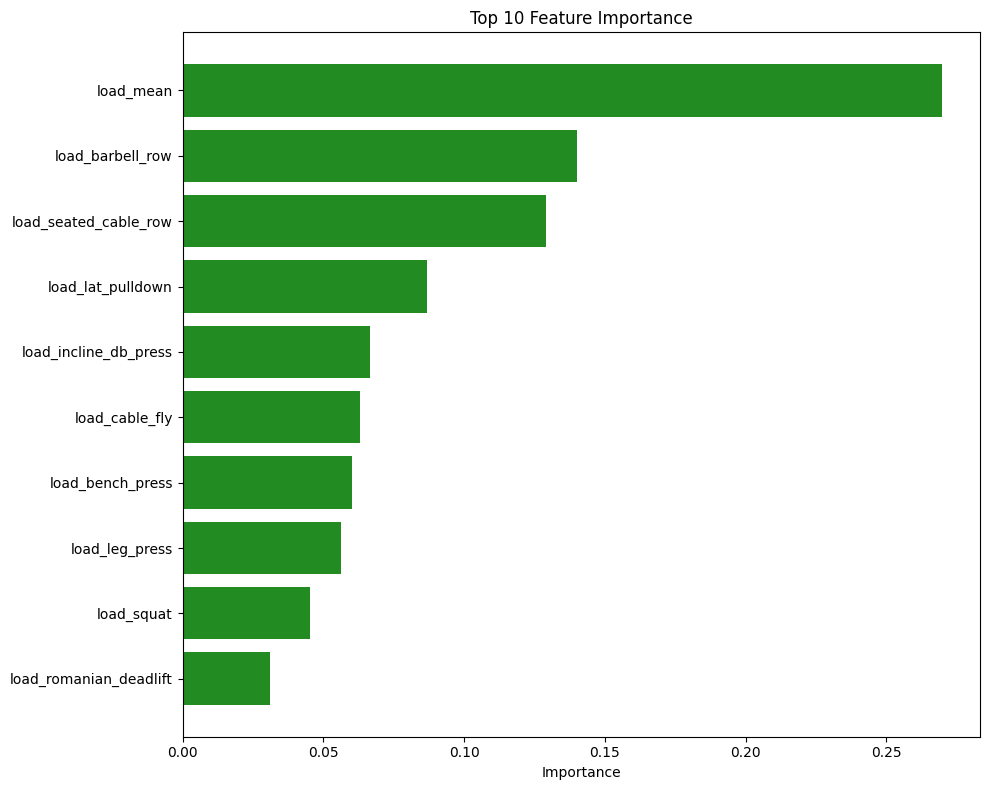

In [20]:
print("="*80)
print("FEATURE IMPORTANCE")
print("="*80)

feat_imp = pd.DataFrame({'feature': feature_cols, 'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)

print("\nTop 10:")
for i, row in feat_imp.head(10).iterrows():
    print(f"  {row['feature']:<35s}: {row['importance']:.4f}")

plt.figure(figsize=(10,8))
top_10 = feat_imp.head(10)
plt.barh(range(10), top_10['importance'], color='forestgreen')
plt.yticks(range(10), top_10['feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
print("\n(OK) Salvato: feature_importance.png")
plt.show()
print("="*80)

---
# SEZIONE 12: Confusion Matrix

Analisi **errori per classe**. Ideale: errori solo su classi adiacenti.
---

Confusion Matrix:
[[36  0  0]
 [ 0 52  2]
 [ 0  0 12]]
(OK) Salvato: confusion_matrix.png


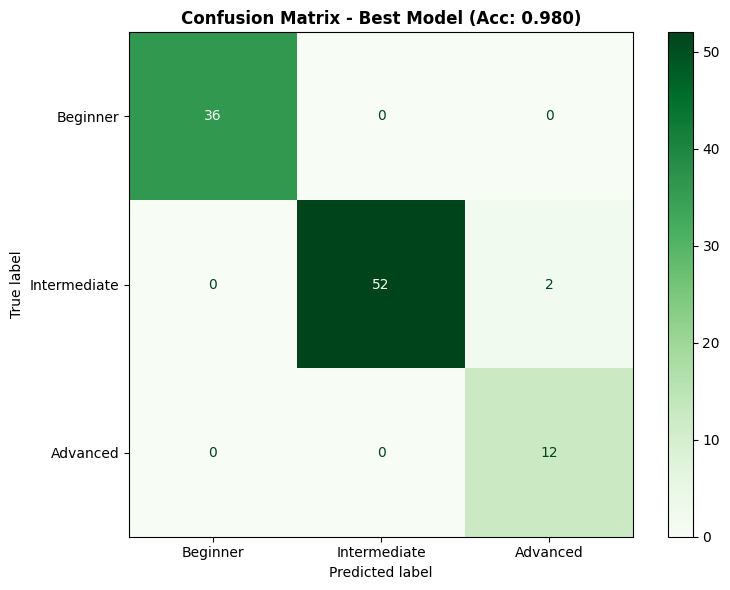


Classification Report:
              precision    recall  f1-score   support

    Beginner       1.00      1.00      1.00        36
Intermediate       1.00      0.96      0.98        54
    Advanced       0.86      1.00      0.92        12

    accuracy                           0.98       102
   macro avg       0.95      0.99      0.97       102
weighted avg       0.98      0.98      0.98       102



In [21]:
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=['Beginner', 'Intermediate', 'Advanced'])
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap='Greens')
plt.title(f'Confusion Matrix - Best Model (Acc: {test_acc_best:.3f})', fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
print("(OK) Salvato: confusion_matrix.png")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Beginner', 'Intermediate', 'Advanced']))

---
# SEZIONE 13: Salvataggio

**6 file** generati: modello, scaler, feature names, risultati, grafici.
---

In [22]:
print("="*80)
print("SALVATAGGIO")
print("="*80)

joblib.dump(best_model, 'best_model_rf.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\n(OK) best_model_rf.pkl")
print("(OK) scaler.pkl")

with open('feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_cols))
print("(OK) feature_names.txt")

import json
with open('results.json', 'w') as f:
    json.dump({'test_acc': float(test_acc_best), 'cv_score': float(grid.best_score_), 'params': grid.best_params_}, f, indent=2)
print("(OK) results.json")

print(f"\n{'='*80}")
print("MODELING COMPLETATO ")
print(f"{'='*80}")
print(f"\n(!!) Best: Random Forest (Tuned) (!!)")
print(f"   Test Acc: {test_acc_best:.3f}")
print(f"   Features: {len(feature_cols)}")
print("="*80)

SALVATAGGIO

(OK) best_model_rf.pkl
(OK) scaler.pkl
(OK) feature_names.txt
(OK) results.json

MODELING COMPLETATO 

(!!) Best: Random Forest (Tuned) (!!)
   Test Acc: 0.980
   Features: 19
